In [2]:
# Theoretical limit with multi-agents and multi-actions on a/b side
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve
from itertools import product
from scipy.special import comb

In [5]:
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

# Sensitivity analysis on these params
n_agents = 2
sig = 0.4
inven_factor = 0.05
# maker rebate is the incentive for liquidity provider
maker_rebate = 0.1
# taker fee is the cost for liquidity taker, usually >= maker_rebate
taker_fee = 0.15

# Params unchanged
n_tick = 4
n_states = n_tick**2
# n_actions is for one side, then n_actions**2 is for joint ask/bid action
n_actions = 4

tick_space = np.arange(1, n_tick+1)
weights =  0.2*np.maximum(tick_space + taker_fee - 1, 0.0)**2

quote_dist = np.ones((n_actions, n_tick))*0.3/(n_actions-1)
for i in range(n_actions):
    quote_dist[i, i] = 0.7



def reward_cal(mo_size, LOB):
    # Compute profits for all agents
    # mo_size: int, LOB: n_agents * quotes
    reward = np.zeros(n_agents)
    order = np.zeros(n_agents)

    if mo_size == 0:
        return order, reward

    # the smallest index to fill market orders
    indx = np.where(np.cumsum(np.sum(LOB, axis=0)) >= mo_size)[0]
    if len(indx) == 0:
        # eat all limit orders
        for agent in range(n_agents):
            reward[agent] = np.dot(LOB[agent], tick_space + maker_rebate)
            order[agent] = np.sum(LOB[agent])
    elif indx[0] > 0:
        for agent in range(n_agents):
            reward[agent] = np.dot(LOB[agent, :indx[0]], tick_space[:indx[0]] + maker_rebate)
            order[agent] = np.sum(LOB[agent, :indx[0]])
        order_left_dist = (mo_size - np.sum(LOB[:, :indx[0]]))*LOB[:, indx[0]]/np.sum(LOB[:, indx[0]])
        order += order_left_dist
        reward += order_left_dist*(tick_space[indx[0]] + maker_rebate)
    elif indx[0] == 0:
        order_dist = mo_size * LOB[:, indx[0]] / np.sum(LOB[:, indx[0]])
        order = order_dist
        reward = order_dist * (tick_space[0] + maker_rebate)

    return order, reward

# reward matrix
R = np.zeros((n_actions**2, n_actions**2))

for act_i in range(n_actions**2):
    for act_j in range(n_actions**2):

        ask_action = (np.array([act_i, act_j]) // n_actions).astype(int)
        bid_action = (np.array([act_i, act_j]) % n_actions).astype(int)
        
        ask_LOB = np.zeros((n_agents, n_tick))
        bid_LOB = np.zeros((n_agents, n_tick))
        
        for agent in range(n_agents):
            ask_LOB[agent, :] =  np.floor(quote_dist[ask_action[agent], :] * 20)
            bid_LOB[agent, :] =  np.floor(quote_dist[bid_action[agent], :] * 20)
         
        ask_arr_rate = np.exp(-np.dot(np.sum(ask_LOB, axis=0)/np.sum(ask_LOB)/sig, weights))
        ask_mo = 20 * n_agents * ask_arr_rate

        bid_arr_rate = np.exp(-np.dot(np.sum(bid_LOB, axis=0) / np.sum(bid_LOB)/sig, weights))
        bid_mo = 20 * n_agents * bid_arr_rate

        bid_filled, bid_reward = reward_cal(bid_mo, bid_LOB)
        ask_filled, ask_reward = reward_cal(ask_mo, ask_LOB)

        # Inventory risk
        R[act_i, act_j] = (bid_reward + ask_reward - inven_factor * (bid_filled - ask_filled) ** 2)[0]

In [ ]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(14, 12))
# labels = ['{:,.2f}'.format(x) for x in space]
labels = np.arange(n_actions**2) + 1
ax = sns.heatmap(R.transpose(), xticklabels=labels, yticklabels=labels, annot=True, fmt=".1f", 
                 annot_kws={"fontsize":14}, cmap=cmap)

ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.xlabel('Our bid/ask actions', fontsize=15)
plt.ylabel('Competitor\'s bid/ask actions', fontsize=15)
cbar = ax.collections[0].colorbar
# here set the labelsize by 14
cbar.ax.tick_params(labelsize=14)
# cbar = ax.figure.colorbar(ax.collections[0])
# plt.savefig('reward.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)
plt.show()

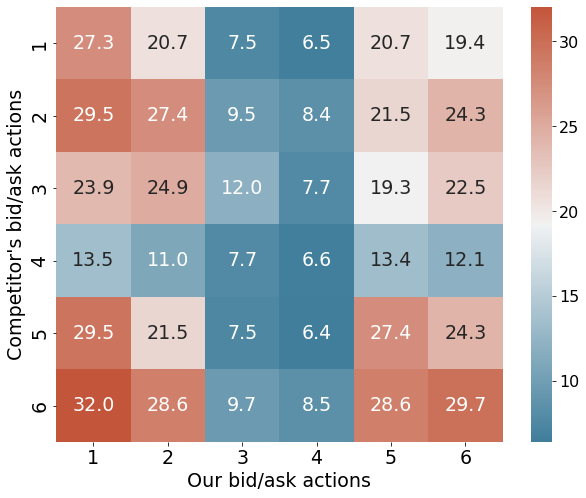

In [6]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(10, 8))
# labels = ['{:,.2f}'.format(x) for x in space]
labels = np.arange(1, 7)
ax = sns.heatmap(R[:6,:6].transpose(), xticklabels=labels, yticklabels=labels, annot=True, fmt=".1f", 
                 annot_kws={"fontsize":19}, cmap=cmap)

ax.tick_params(axis = 'both', which = 'major', labelsize=19)
plt.xlabel('Our bid/ask actions', fontsize=19)
plt.ylabel('Competitor\'s bid/ask actions', fontsize=19)
cbar = ax.collections[0].colorbar
# here set the labelsize by 14
cbar.ax.tick_params(labelsize=16)
# cbar = ax.figure.colorbar(ax.collections[0])
plt.savefig('beta01reward.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
weights

In [ ]:
29.7/(1-0.95)

In [ ]:
2*1 + 10*2

In [ ]:
22/12 + 0.2